In [107]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T
device = 'cpu' #не просто же так в машине xeon 14-ядерный
from torchsampler import ImbalancedDatasetSampler
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [71]:
df=pd.read_csv('creditcard_2023.csv')
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [72]:
target = df['Class']
df=df.drop(['Class'],axis=1)

In [73]:
target.tail

<bound method NDFrame.tail of 0         0
1         0
2         0
3         0
4         0
         ..
568625    1
568626    1
568627    1
568628    1
568629    1
Name: Class, Length: 568630, dtype: int64>

In [74]:
target.describe()

count    568630.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           0.5
75%           1.0
max           1.0
Name: Class, dtype: float64

In [75]:
target.value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [76]:
df=df.drop(['id'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97


In [77]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [78]:
df.isna().sum().sum()

0

In [79]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,...,-1.579456e-17,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,...,-7.814784e+01,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,...,-3.502399e-01,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,...,-1.233776e-01,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,...,2.482164e-01,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,...,2.987281e+01,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000


In [80]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df=pd.DataFrame(rs.fit_transform(df),columns = df.columns)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.119468,-0.402001,1.953233,-0.007309,0.066273,0.693238,0.352875,-0.064627,0.562614,0.317210,...,0.358555,-0.232559,0.256645,-0.190941,0.110964,0.121787,-0.324140,0.143479,-0.213753,0.496764
1,0.771660,-0.265168,0.436443,-0.261105,0.267381,0.370777,0.213839,-0.077619,0.225996,0.225945,...,-0.184820,-0.500940,-0.606087,0.353782,-0.438725,0.179578,0.236357,-0.117594,-0.078854,-0.458942
2,-0.119199,-0.979834,1.352430,-0.281891,-0.009583,1.420813,0.630207,0.079097,-0.313671,0.362005,...,0.810468,0.103080,0.765148,2.554339,-0.865601,-0.541016,-0.230692,-0.199296,-0.359781,-0.794279
3,-0.041857,-0.449350,1.366753,-0.745706,0.229665,1.128156,0.351954,0.206191,-0.264381,0.264355,...,-0.425838,-0.348250,-0.011404,-0.392428,-1.411675,0.916673,-0.386316,0.011885,0.097204,-0.554667
4,-0.080963,-0.035395,1.194753,-0.274779,0.034146,0.478808,0.525620,-0.409657,0.848749,0.596529,...,0.619284,-0.221212,0.793252,-0.259256,0.219371,-0.367630,0.830037,0.307712,0.675087,0.187692


In [81]:
X=df.values
y=target.values

In [82]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = np.array([x for x in class_weights], dtype=np.float32)
class_weights

array([1., 1.], dtype=float32)

In [83]:
X_train, X_dum, y_train, y_dum=train_test_split(X,y, test_size=0.2)
X_val, X_test, y_val, y_test= train_test_split(X_dum, y_dum ,test_size=0.5)

In [84]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data)
      self.targets = torch.LongTensor(targets)
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def get_labels(self):
    return self.targets

  def __len__(self):
      return len(self.data)

In [85]:
train_dataset=MyDataset(X_train,y_train)
val_dataset=MyDataset(X_val,y_val)
test_dataset=MyDataset(X_test,y_test)

In [86]:
train_dataset[0]

(tensor([-0.1572,  0.6567, -0.4758,  0.2878, -0.2332, -0.7335, -0.7991,  1.3573,
         -0.2238, -0.9471,  0.8444, -0.8009,  0.9961, -0.6401, -0.3241, -0.5778,
         -0.7026, -0.1603,  0.7569,  0.5668,  0.4619, -0.3962, -0.4150, -0.5224,
          0.0822,  0.9029,  0.5177,  0.0984, -0.1667]),
 tensor(1))

In [87]:
print(f'''Длина тестовой выборки: {len(test_dataset)}
Длина валидационной выборки: {len(val_dataset)}
Длина тренировочной выборки: {len(train_dataset)}''')

Длина тестовой выборки: 56863
Длина валидационной выборки: 56863
Длина тренировочной выборки: 454904


In [88]:
batch_size=16 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,
                          sampler=ImbalancedDatasetSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [89]:
class Classification_Model_FFNN(nn.Module):
  def __init__(self, num_inputs, num_classes):
      super(Classification_Model_FFNN, self).__init__()
      self.pipe = nn.Sequential(
          nn.Linear(num_inputs, 64, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(64),

          nn.Linear(64, 48, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(48),

          nn.Linear(48, 32, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(32),

          nn.Linear(32, 16, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(16),

          nn.Linear(16, num_classes))

  def forward(self, x):
      return self.pipe(x)

In [90]:
model=Classification_Model_FFNN(29,2)
model.to(device);

In [91]:
from torchinfo import summary
summary(model,input_size=(1, 29))

Layer (type:depth-idx)                   Output Shape              Param #
Classification_Model_FFNN                [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 64]                   1,856
│    └─ReLU6: 2-2                        [1, 64]                   --
│    └─BatchNorm1d: 2-3                  [1, 64]                   128
│    └─Linear: 2-4                       [1, 48]                   3,072
│    └─ReLU6: 2-5                        [1, 48]                   --
│    └─BatchNorm1d: 2-6                  [1, 48]                   96
│    └─Linear: 2-7                       [1, 32]                   1,536
│    └─ReLU6: 2-8                        [1, 32]                   --
│    └─BatchNorm1d: 2-9                  [1, 32]                   64
│    └─Linear: 2-10                      [1, 16]                   512
│    └─ReLU6: 2-11                       [1, 16]                   --
│   

In [92]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

In [93]:
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)

In [94]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [95]:
train_losses=[]
train_accs=[]
def train(model,epoch):
  print('\nEpoch : %d'%epoch)
  model.train() # веса модели можно обновлять
  running_loss= 0.
  running_acc = 0.
  for data in tqdm(train_loader):
      inputs, targets=data[0].to(device),data[1].to(device) # распаковываем пакеты
      optimizer.zero_grad() # обнуляем градиенты
      outputs=model(inputs) # считаем предсказания - прямой проход модели
      loss=criterion(outputs,targets) # ошибка пакета
      loss.backward() # обратное распространение ошибки
      optimizer.step() # итерация алгоритма оптимизации

      running_loss += loss.item()
      running_acc += accuracy(outputs,targets)

  train_loss=running_loss/len(train_loader)
  train_acc=running_acc/len(train_loader)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  print('Средняя ошибка модели на тренировочной выборке: %.4f'%(train_loss)+'   Средняя точность модели на тренировочной выборке: %.4f'%(train_acc))

In [96]:
val_losses=[]
val_accs=[]
def val(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval() # веса модели заморожены
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(val_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)

            running_loss += loss.item()
            running_acc += accuracy(outputs,targets)

        val_loss=running_loss/len(val_loader)
        val_acc=running_acc/len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print('Средняя ошибка модели на валидационной выборке: %.4f'%(val_loss)+'   Средняя точность модели на валидационной выборке: %.4f'%(val_acc))

In [97]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [98]:
max_epochs=100
best_acc=0.0
early_stopper = EarlyStopper(patience=5, min_delta=0.1)
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    val(model,epoch)
    if val_accs[-1] > best_acc:
       torch.save(model, 'best-model.pt')
       best_acc = val_accs[-1]
    if early_stopper.early_stop(val_losses[-1]):
      break


Epoch : 1


100%|██████████| 28432/28432 [05:13<00:00, 90.66it/s]


Средняя ошибка модели на тренировочной выборке: 0.1947   Средняя точность модели на тренировочной выборке: 0.9542

Epoch : 1


100%|██████████| 3554/3554 [00:11<00:00, 320.37it/s]


Средняя ошибка модели на валидационной выборке: 0.1765   Средняя точность модели на валидационной выборке: 0.9658

Epoch : 2


100%|██████████| 28432/28432 [05:12<00:00, 90.88it/s] 


Средняя ошибка модели на тренировочной выборке: 0.1931   Средняя точность модели на тренировочной выборке: 0.9549

Epoch : 2


100%|██████████| 3554/3554 [00:11<00:00, 315.46it/s]


Средняя ошибка модели на валидационной выборке: 0.1632   Средняя точность модели на валидационной выборке: 0.9626

Epoch : 3


100%|██████████| 28432/28432 [05:07<00:00, 92.53it/s] 


Средняя ошибка модели на тренировочной выборке: 0.1926   Средняя точность модели на тренировочной выборке: 0.9551

Epoch : 3


100%|██████████| 3554/3554 [00:11<00:00, 305.51it/s]


Средняя ошибка модели на валидационной выборке: 0.1881   Средняя точность модели на валидационной выборке: 0.9627

Epoch : 4


100%|██████████| 28432/28432 [05:12<00:00, 91.01it/s] 


Средняя ошибка модели на тренировочной выборке: 0.1920   Средняя точность модели на тренировочной выборке: 0.9551

Epoch : 4


100%|██████████| 3554/3554 [00:11<00:00, 320.41it/s]


Средняя ошибка модели на валидационной выборке: 0.1820   Средняя точность модели на валидационной выборке: 0.9634

Epoch : 5


100%|██████████| 28432/28432 [05:07<00:00, 92.45it/s] 


Средняя ошибка модели на тренировочной выборке: 0.1922   Средняя точность модели на тренировочной выборке: 0.9554

Epoch : 5


100%|██████████| 3554/3554 [00:09<00:00, 357.46it/s]


Средняя ошибка модели на валидационной выборке: 0.1889   Средняя точность модели на валидационной выборке: 0.9626

Epoch : 6


  3%|▎         | 844/28432 [00:12<06:50, 67.14it/s] 


KeyboardInterrupt: 

In [99]:
best_acc

tensor(0.9658)

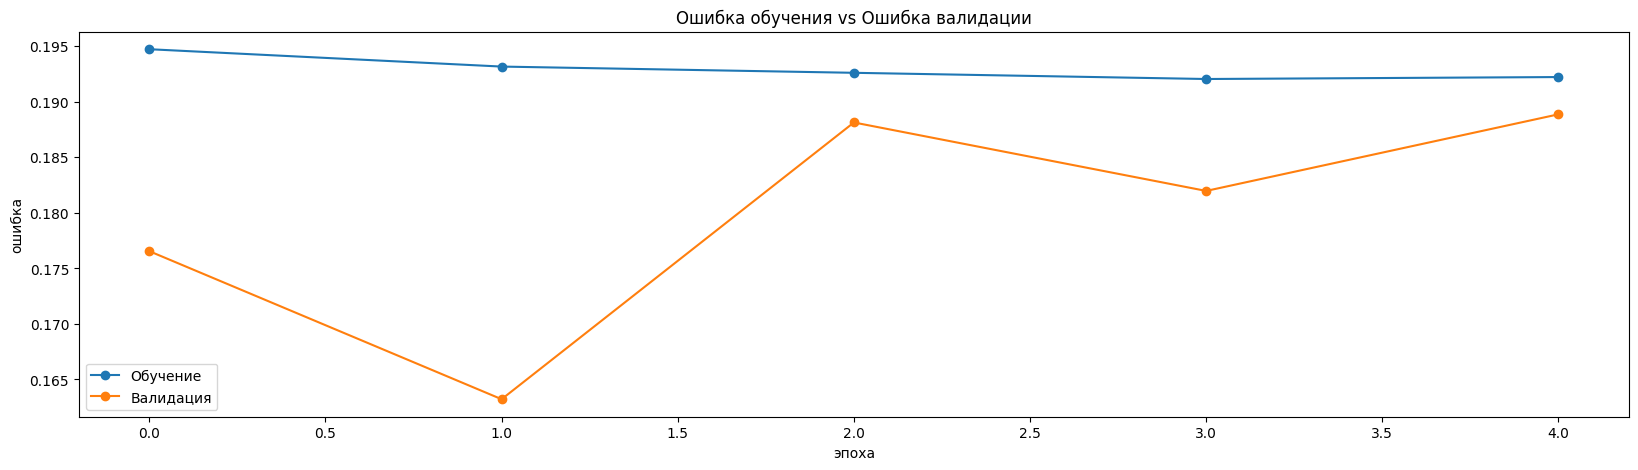

In [100]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

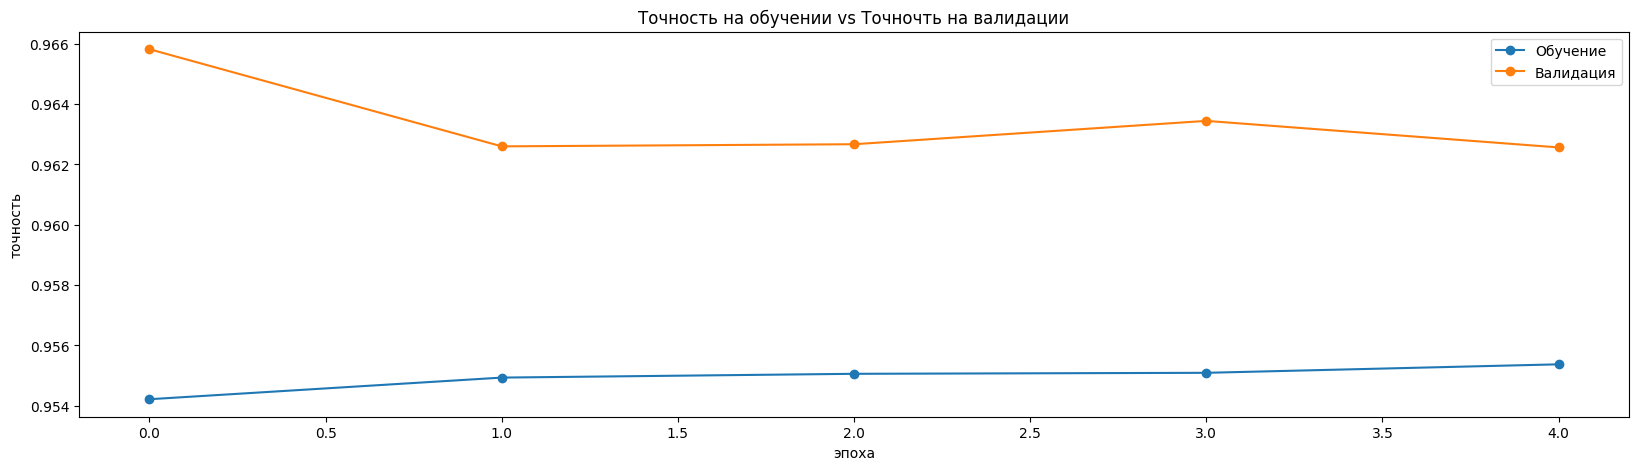

In [101]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_accs,'-o')
plt.plot(val_accs,'-o')
plt.xlabel('эпоха')
plt.ylabel('точность')
plt.legend(['Обучение','Валидация'])
plt.title('Точность на обучении vs Точночть на валидации')
plt.show()

In [102]:
model = torch.load('best-model.pt');
model.eval();

In [103]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

100%|██████████| 3554/3554 [00:10<00:00, 337.54it/s]


In [104]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)

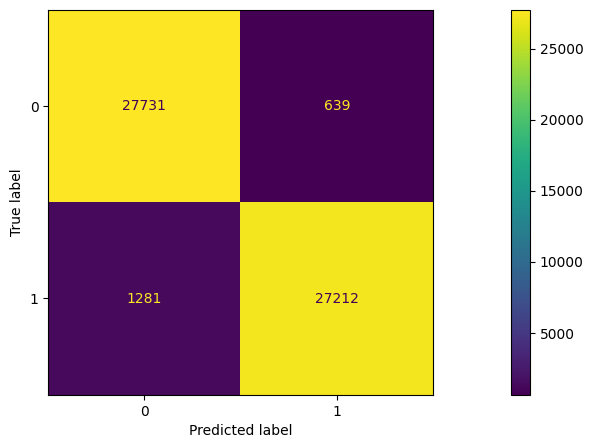

In [105]:
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()

In [106]:
f1_score(targets, predictions,average='micro')

0.9662346341206056